# Transfer Learning and Fine Tuning

__Before starting, we recommend you enable GPU acceleration if you're running on Colab.__

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try:
    import torchbearer
except:
    !pip install torchbearer

## Getting started

Start by downloading and unzipping the data set. The code in the following block will download and unzip the data we're going to use.

In [2]:
from os.path import exists
if not exists('data'):
    !wget -O boat-data.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/eAhIkhhdxgmhRHj/download
    !unzip boat-data.zip

We'll start by exploring the data, and look at how we can get that data loaded into memory through python code. We can just use the `ls` command from with this notebook to explore the data set:

In [3]:
!ls data
!ls data/test

mf.jpg	README.md  test  train	valid
Alilaguna  Gondola	  Motopontonerettangolare  Patanella	    Sandoloaremi   Water
Ambulanza  Lanciafino10m  MotoscafoACTV		   Polizia	    Topa
Barchino   Motobarca	  Mototopo		   Raccoltarifiuti  VaporettoACTV


If you explore the `data` directory you should see three folders:

	- The `train` folder contains the training data & is broken into subdirectories for each class.
	- The `valid` folder contains the validation data & is broken into subdirectories for each class.
	- The `test` folder contains the testing data & is broken into subdirectories for each class.
    
The following displays one of the images:

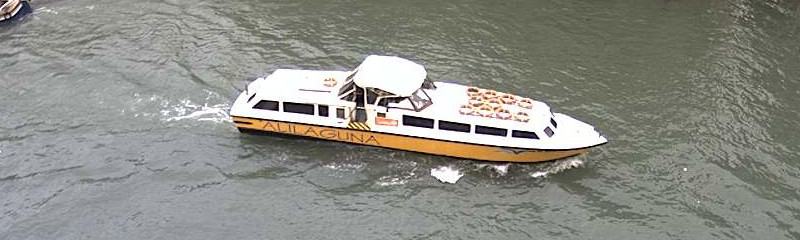

In [4]:
from IPython.display import Image
Image("data/test/Alilaguna/20130412_064059_20202.jpg")

The `torchvision` library has support for directly reading images from a directory structure like the one we have using the `torchvision.datasets.ImageFolder` class. In addition to loading the images directly, `torchvision` provides a mechanism to dynamically augment the data being read by applying random transformations (flipping, rotating, etc), as well as cropping and scaling the images. The following code will generate a visualisation of the first batch of images produced by the data loader:

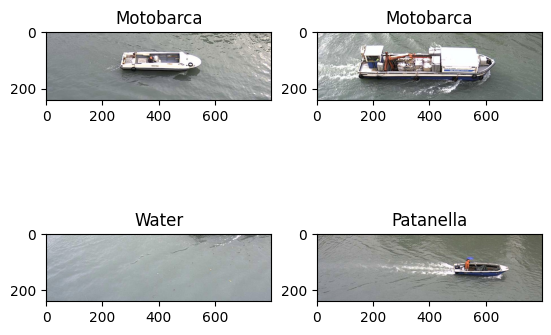

In [5]:
%matplotlib inline

# Plot ad hoc data instances
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy

transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# generate the first batch
(batch_images, batch_labels) = train_loader.__iter__().__next__()

# plot 4 images
plt.subplot(221).set_title(train_dataset.classes[batch_labels[0]])
plt.imshow(batch_images[0].permute(1, 2, 0), aspect='equal')
plt.subplot(222).set_title(train_dataset.classes[batch_labels[1]])
plt.imshow(batch_images[1].permute(1, 2, 0), aspect='equal')
plt.subplot(223).set_title(train_dataset.classes[batch_labels[2]])
plt.imshow(batch_images[2].permute(1, 2, 0), aspect='equal')
plt.subplot(224).set_title(train_dataset.classes[batch_labels[3]])
plt.imshow(batch_images[3].permute(1, 2, 0), aspect='equal')

# show the plot
plt.show()

## A simple CNN for boat classification

Now let's try something a little more challenging and take our `BetterCNN` convolutional network from the experiments with mnist last week, and apply it to the problem of boat classification. Firstly we need to setup the data for training, and it would also be sensible to load the validation data to monitor performance during training, as well as load the test data:

In [6]:
# the number of images that will be processed in a single step
batch_size=128
# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(30, 100)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder("data/valid", transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder("data/test", transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Note that for now we're not using any data augmentation from the training data, however we've structured the code so that we can easily add it by manipulating the transforms that are applied. Note that if we dot that, we probably wouldn't want to do the augmentation of the validation/test sets, so we would need a separate set of transforms for those.

Now we can add the network definition from last week. We'll make a slight change to the previous `BetterCNN` function so that it allows us to specify the number of input channels and the number of output classes in the constructor. In the following block you'll need to paste your implementation of the `BetterCNN` forward method from last week:

In [7]:
import torch
import torch.nn.functional as F
from torch import nn
import torchbearer
from torchbearer import Trial
from torch import optim

# Model Definition
class BetterCNN(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels_in, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(1725, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, n_classes)

    def forward(self, x):
        # raise NotImplementedError()
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 1725)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

We're now in a position to add the code to fit the model - we'll use `torchbearer` to help us out:

In [8]:
import torchbearer
from torchbearer import Trial
from torch import optim

model = BetterCNN(3, len(train_dataset.classes))

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)

0/10(t):   0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 

Once the model is trained, we can investigate the performance on the test data. Rather than just look at the average accuracy we need to dig into a little more detail, so we'll use the `classification_report` method in scikit-learn to compute per-class precision and recall values:

In [ ]:
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()
true_classes = list(x for (_,x) in test_dataset.samples)

from sklearn import metrics
print(metrics.classification_report(true_classes, predicted_classes, target_names=train_dataset.classes))

In this particular case you should observe that the overall accuracies are a bit mixed; whist the average is high, it is clear that our model doesnt work well for some classes. Be aware though that we're using a relatively small set of both training and validation data, and that there is a very high bias in the class distribution which inevitably could lead to higher accuracies because of common classes. As we mentioned in the lab last week, this network architecture isn't any thing like one that has won the image classification challenges.

## Using a better network model - transferring and finetuning a pretrained ResNet

Training a network from scratch can be a lot of work. Is there some way we could take an existing network trained on some data with one set of labels, and adapt it to work on a different data set with different labels? Assuming that the inputs of the network are equivalent (for example, image with the same number of bands and size), then the answer is an emphatic yes! This process of "finetuning" a pre-trained network has become common-place as its much faster an easier than starting from scratch. This approach will also help us better work with the small amount of data that we have to train with.

Let's try this in practice - we'll start by loading a pre-trained network architecture called a Deep Residual Network (or ResNet for short) that has been trained on the 1000-class ImageNet dataset. The ResNet architecture is very deep - it has many (in our case 50) convolutional layers and is currently one of the best performing architectures on the ImageNet challenge. The PyTorch model zoo contains code that implements the resnet50 architecture, and automatically downloads the pre-trained model weights. We'll start by using this to load the model and test it by classifying an image:

In [9]:
from torchvision.models import resnet50
from urllib.request import urlopen

imagenet_labels = urlopen("https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt").read().decode('utf-8').split("\n")

model = resnet50(pretrained=True)
model.eval()

preprocess_input = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

from PIL import Image as PImage
img_path = 'data/mf.jpg'
img = PImage.open(img_path)

print(preprocess_input(img))
preds = model(preprocess_input(img).unsqueeze(0))

_, indexes = preds.topk(5)
for i in indexes[0]:
    print('Predicted:', imagenet_labels[i])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[[ 0.7762,  0.7762,  0.7762,  ...,  0.6734,  0.6734,  0.6734],
         [ 0.8104,  0.8104,  0.8104,  ...,  0.7248,  0.7248,  0.7077],
         [ 0.8104,  0.8276,  0.8276,  ...,  0.7933,  0.7762,  0.7419],
         ...,
         [-1.4500, -1.1418, -1.3302,  ..., -0.9705,  0.1426,  0.0227],
         [-1.4843, -1.5357, -1.5528,  ..., -0.3369, -0.3541, -0.4226],
         [-1.6555, -1.8097, -1.5699,  ..., -0.0287, -0.5082, -0.6794]],

        [[ 0.9230,  0.9230,  0.9230,  ...,  0.8354,  0.8354,  0.8354],
         [ 0.9580,  0.9580,  0.9580,  ...,  0.8880,  0.8880,  0.8704],
         [ 0.9580,  0.9755,  0.9755,  ...,  0.9580,  0.9405,  0.9055],
         ...,
         [-1.5630, -1.2829, -1.4230,  ..., -1.2479, -0.1275, -0.3200],
         [-1.5805, -1.6681, -1.6331,  ..., -0.5476, -0.6001, -0.7402],
         [-1.7556, -1.9132, -1.6155,  ..., -0.2500, -0.7752, -0.9328]],

        [[ 1.1759,  1.1759,  1.1759,  ...,  1.1237,  1.1237,  1.1237],
         [ 1.2108,  1.2108,  1.2108,  ...,  1

If you run the above code (it will take a little longer the first time as the model is downloaded), it should indicate that our input image was likely to contain a fish! Run the following block to display the image and verify this.

The `preprocess_input` transformation in the above is important - it's responsible for applying the same normalisation operations to our input image as were applied to the images when the network was trained, as well as getting the image to the 224x224 size expected by the network.

In [ ]:
Image("data/mf.jpg")

In the above code to load the pretrained ResNet model, after the model is loaded we call `model.eval()`. Why is this? What happens if you don't make this call before using the model? __Write your answers in the following block:__

YOUR ANSWER HERE

We're now in a position to start to hack the model structure. Fundamentally we need to first remove the classification layer at the end of the model and replace it with a new one (with a different number of classes). Let's print out the model structure:

In [ ]:
print(model)

Looking at the model we can see that really what we want to do is just replace the last fully connected layer with one with a different number of features. There are many ways in which PyTorch allows us to do this, but the simplest is to just do a direct replacement.

We'll also make a small change to the pooling layer before the last fully connected layer; in the default ResNet model 2D average pooling is used to reduce a 2048x7x7 tensor to 2048x1x1 by using a 7x7 pooling window. This is precisely the definition of Global Average Pooling, however it is implemented with a fixed size window. As our boat images are not square, it would be nice if we could use them at a high resolution without cropping. We can replace the pooling layer with an `nn.AdaptiveAvgPool2d` layer that will perform real Global Average Pooling by dynamically scaling the window to whatever spatial size the input feature maps have:

In [23]:
model = resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The actual process of finetuning involves us now training the model with our own data. As the network is already largely trained, we'll likely want to use a small learning rate so not to make big changes in weights. Often we'll first "freeze" the weights of the already trained layers whilst we learn initial weights for our new layer to avoid overfitting while training:

In [16]:
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases

optimiser = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4) #only optimse non-frozen layers

If we have lots of training data we could then unlock these layers and perform end-to-end finetuning afterwards. The Standford CS231n course pages have lots of useful hints on fine-tuning: http://cs231n.github.io/transfer-learning/

__Use the following block to try finetuning the resnet50 with the boat data. You'll need a GPU to do this effectively as it's _rather_ slow!__

In [24]:
# YOUR CODE HERE
# raise NotImplementedError()
for param in model.parameters():
  param.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=8e-5) #only optimse non-frozen layers

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
trial.run(epochs=15)
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)

0/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

0/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

1/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

2/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

3/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

4/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

5/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

6/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

7/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

8/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

9/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

10/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

11/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

12/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

13/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/15(t):   0%|          | 0/28 [00:00<?, ?it/s]

14/15(v):   0%|          | 0/4 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/4 [00:00<?, ?it/s]


{'val_loss': 0.478981077671051, 'val_acc': 0.8582278490066528}


Use the following block to note down the performance you achieve by finetuning the model. How does this compare to the `BetterCNN` model used earlier?

Finetune the Resnet50

Main layers frozen
1.   Adam 10 epochs lr 1e-4 val_loss 1.02 val_acc 0.67
2.   Adam 20 epochs lr 5e-5 val_loss 1.03 val_acc 0.67

All layers unfrozen
1.   Adam 20 epochs lr 1e-4 val_loss 0.44 val_acc 0.855
2.   Adam 10 epochs lr 8e-5 val_loss 0.46 val_acc 0.863
3.   Adam 15 epochs lr 8e-5 val_loss 0.47 val_acc 0.858




## Extracting features from a model

Sometimes you want to do things that are not so easily accomplished with a deep network. You might want to build classifiers using very small amounts of data, or you might want a way of finding things in photographs that are in some way semantically similar, but don't have exactly the same classes. CNNs can actually help here using a technique known often called transfer learning (and related to the fine tuning that we just looked at). If we assume we have a trained network, then by extracting vectors from the layers before the final classifier we should have a means of achieving these tasks, as the vectors are likely to strongly encode semantic information about the content of the input image. If we wanted to quickly train new classifiers for new classes, we could for instance just use a relatively simple linear classifier trained on these vectors. If we wanted to find semantically similar images, we could just compare the Euclidean distance of these vectors.

PyTorch makes it pretty easy to get these vector representations. The following code gets a resnet model in which the a feature vector is computed from the penultimate layer of the network by applying a _global average pooling_ operation over the feature maps:

In [ ]:
from torch import nn
model = resnet50(pretrained=True)
feature_extractor_model = nn.Sequential(*list(model.children())[:-2], nn.AdaptiveAvgPool2d((1,1)))
feature_extractor_model.eval()
feature_extractor_model = feature_extractor_model.to(device)

With this model, extract the features for some inputs. To demonstrate, we can put the whole thing together and generate a vector from an image:

In [ ]:
transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

img_path = 'data/test/Alilaguna/20130412_064059_20202.jpg'
img = PImage.open(img_path)
feature = feature_extractor_model(preprocess_input(img).unsqueeze(0).to(device))
print('Feature shape:', feature.shape)
print('Feature data:', feature[0].reshape(-1))

Use the following block to generate some features for some different images in the test set, and calculate the Euclidean distances between these features.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In the following block describe how the Euclidean distances compare to your perception of similarity between the images:

YOUR ANSWER HERE

Let's now explore how features from a ResNet could be used with a classifier that works well with small amounts of training data - a Support Vector Machine. Use the following block to train a multiclass SVM using the `sklearn.svm.SVC` class to learn the boat classes using the features extracted by the ResNet50 with the default imagenet weights. Once you've trained it (and optimised the parameters) print out a classification report.

We've provided all the features and labels in the form of `numpy` arrays so you don't have to extract them (which can take a few minutes; you can view the code we used [here](https://github.com/ecs-vlc/COMP6258/blob/master/docs/labs/lab6/genfeats.py)):

In [ ]:
import numpy as np

if not exists('training_features.npy'):
    !wget -O Resnet50Features.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/P68OB07DquOwSR7/download
    !unzip Resnet50Features.zip

training_features = np.load('training_features.npy')
training_labels = np.load('training_labels.npy')

valid_features = np.load('valid_features.npy')
valid_labels = np.load('valid_labels.npy')

testing_features = np.load('testing_features.npy')
testing_labels = np.load('testing_labels.npy')

# YOUR CODE HERE
raise NotImplementedError()

Use the following block to reflect on how the test performance compares to the finetuned ResNet. What is the difference in time taken to train and evaluate the different approaches?

YOUR ANSWER HERE